In [47]:
FIGURES_PATH = 'out/figures/'
DATASETS_PATH = 'out/datasets/'

In [48]:
import pandas as pd
from datetime import datetime
import os
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import psutil
import matplotlib.colors as mcolors
import random
from tqdm import tqdm

from helper import *

In [49]:
NROWS = None

In [50]:
data = pd.read_csv(DATASETS_PATH + 'data_processed.csv', nrows=NROWS).drop(columns=['Unnamed: 0'])
data['datetime'] = pd.to_datetime(data['datetime'])
data

,gid,transaction_key,store_id,product_id,line_item_price,line_item_cost,line_type,datetime,category_id,weekday,line_quantity
0,0,0,2,0,2990.0,2516.10,0,2022-04-18 12:22:18,49788.0,0,1.0
1,1,1,3,1,1413.0,1206.73,1,2022-08-26 18:00:29,140669.0,4,2.0
2,1,1,3,2,338.0,179.51,1,2022-08-26 18:00:29,157827.0,4,4.0
3,1,1,3,3,1634.0,1402.83,1,2022-08-26 18:00:29,NaN,4,1.0
4,1,1,3,4,78.0,61.70,1,2022-08-26 18:00:29,484922.0,4,40.0
...,...,...,...,...,...,...,...,...,...,...,...
20662670,861563,3945281,2,70820,1925.0,1469.14,0,2022-09-08 11:14:12,381032.0,3,1.0
20662671,861563,3945281,2,3161,43.0,44.66,0,2022-09-08 11:14:12,33888.0,3,22.0
20662672,861563,3945281,2,2612,950.0,969.86,0,2022-09-08 11:14:12,13517.0,3,1.0
20662673,861563,3945281,2,51,4.0,NaN,0,2022-09-08 11:14:12,NaN,3,1.0


### Функции вывода графиков

In [51]:
def scatter_prices(data, line_article_id):
    these_prices = data.loc[data['product_id'] == line_article_id][['line_item_price', 'datetime', 'line_quantity']]
    grouped_prices = these_prices.groupby(['line_item_price'])
    ans = grouped_prices['line_quantity'].apply(lambda x: x.sum())

    ans_cnt = grouped_prices['line_quantity'].apply(lambda x: len(x))
    cnt = (ans_cnt.array - ans_cnt.array.min()) / (ans_cnt.array.max() - ans_cnt.array.min())
    cnt *= 50

    prices, counts = ans.axes, ans.array

    fig1, ax1 = plt.subplots(figsize=(20, 10))
    fig2, ax2 = plt.subplots(figsize=(20, 10))

    fig1.suptitle('Items')
    fig2.suptitle('Buyers')

    ax1.set_xlabel("Price, RUR")
    ax1.set_ylabel("Count of items")
    ax1.grid(axis='x', which='major')

    ax1.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax1.scatter(prices[0], counts, s=cnt, c=counts, cmap='cool')

    ax2.set_xlabel("Price, RUR")
    ax2.set_ylabel("Count of buyers")
    ax2.grid(axis='x', which='major')

    ax2.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax2.scatter(prices[0], cnt, s=cnt, c=counts, cmap='cool')


    # plot = ax2.pcolor(counts)
    # fig2.colorbar(plot)

# scatter_prices(data, 15058563)


In [52]:
def scatter_mean_prices(data, ylim=None):
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.scatter(data.index, data['average_price'], s=0.2)

    x = data['average_price']
    m, s = x.mean(), x.std()

    ax.axhline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axhline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axhline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_ylim(bottom=0, top=ylim)
    ax.set_xlim(left=0)
    ax.set_xlabel('Users')
    ax.set_ylabel('Mean price')
    ax.set_title('Mean prices')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_mean_prices')

In [97]:
def scatter_hist_of_prices(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['average_price'].values
    m, s = x.mean(), x.std()


    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)
    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')

    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Mean price of purchases')
    ax.set_ylabel('Count of buyers')
    ax.set_title('Histogram of frequency')
    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_hist')

In [98]:
def scatter_hist_of_products(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['line_item_price'].values

    m, s = x.mean(), x.std()
    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Price of product')
    ax.set_ylabel('Count of products')
    ax.set_title('Histogram of frequency')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'products_hist')

In [99]:
def scatter_hist_of_weekdays(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    x = data['weekday'].values

    ax.hist(x, bins=7, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.set_xlabel('Weekday')
    ax.set_ylabel('Count of purchases')
    ax.set_title('Histogram of weekdays')
    ax.set_xticks([i for i in range(0, 7)], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation='vertical')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'weekdays_hist')

In [100]:
def scatter_pie_of_prices(data, nbins=5, top_limit=10_000):
    fig, ax = plt.subplots(figsize=(10, 10))
    x, bin_edges = np.histogram(data['line_item_price'].values, bins=nbins, range=(0, top_limit))
    colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))
    ax.pie(x, colors=colors, radius=2, center=(4, 4), labels=['< ' + str(round(i)) + ' RUB' for i in bin_edges[1:]],
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, autopct='%1.1f%%')


    plt.savefig(FIGURES_PATH + 'pie_of_prices')

In [57]:
def plot_over_time(data):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Count of products')
    plt.title('Product sales')

    dates = data['datetime'].dt.date.value_counts()
    dates_ma = dates.rolling(5).mean()
    dates_ma.plot(alpha=0.3, color='r')

    dates.plot()
    plt.savefig(FIGURES_PATH + 'plot_over_time')

In [58]:
def scatter_hist_over_time(data, nbins=None, plot_ma=False):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Count of products')
    plt.title('Product sales')

    dates = data['datetime'].dt.date

    mi, ma = dates.min(), dates.max()

    opti_bins = (ma - mi).days
    if nbins is None:
        nbins = opti_bins
    dates.hist(bins=nbins, histtype='bar', edgecolor='black', linewidth=1.1)

    if plot_ma:
        ma = dates.value_counts().rolling(20).mean()
        ma.plot(color='r', alpha=0.4)


    plt.savefig(FIGURES_PATH + 'hist_over_time')



### Анализ

In [59]:
def three_sigmas(ser):
    mean = ser.mean()
    std = ser.std()

    one_sigma = ser.loc[ser > mean - std].loc[ser < mean + std].shape[0] / ser.shape[0]
    two_sigma = ser.loc[ser > mean - 2 * std].loc[ser < mean + 2 * std].shape[0] / ser.shape[0]
    three_sigma = ser.loc[ser > mean - 3 * std].loc[ser < mean + 3 * std].shape[0] / ser.shape[0]
    return one_sigma, two_sigma, three_sigma

In [60]:
pandarallel.initialize(progress_bar=False, use_memory_fs=True, nb_workers=psutil.cpu_count(logical=False))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [61]:
def get_date_info(data):
    data = data[['product_id', 'gid', 'datetime', 'weekday', 'line_item_price']]
    grouped_by_date = data.groupby(by='datetime')

    ans = grouped_by_date[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})

    ans['unique_users'] = grouped_by_date['gid'].apply(lambda x: x.nunique())

    ans['average_price'] = grouped_by_date['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_date['line_item_price'].apply(lambda x: get_median(x))
    ans['average_quantity'] = grouped_by_date['line_quantity'].apply(lambda x: np.mean(x.values))
    ans['average_date_delta'] = grouped_by_date['datetime'].apply(lambda x: get_mean(get_time_delta(x)))

    return ans

In [62]:
# date_info = get_date_info(data)
# date_info

In [63]:
def get_weekday_info(data):
    grouped_by_weekday = data.groupby(by='weekday')
    ans = grouped_by_weekday[['transaction_key']].parallel_apply(lambda x: x.nunique()).rename(columns={'transaction_key': 'unique_receipts'})

    ans['average_receipt_sum'] = grouped_by_weekday[['line_item_price']].parallel_apply(lambda x: x.values.sum() / x.values.shape[0])
    ans['quartile_range'] = grouped_by_weekday['line_item_price'].quantile(0.75) - grouped_by_weekday['line_item_price'].quantile(0.25)
    ans['std'] = grouped_by_weekday['line_item_price'].std()
    ans['unique_users'] = grouped_by_weekday[['gid']].parallel_apply(lambda x: x.nunique())
    return ans
    #
    # return ans

In [64]:
weekday_info = get_weekday_info(data)
weekday_info

,unique_receipts,average_receipt_sum,quartile_range,std,unique_users
weekday,,,,,
0,492895,608.953735,372.0,2083.104492,253792
1,529778,598.853591,369.0,2023.429649,268416
2,537220,596.506865,369.0,2053.690412,270246
3,541067,594.485628,367.0,2040.091186,271714
4,560188,596.373640,367.0,2003.634039,282310
5,675444,606.297089,373.0,1854.980692,333833
6,608690,622.064186,383.0,1884.850623,308027


In [65]:
weekday_info.apply(three_sigmas)

,unique_receipts,average_receipt_sum,quartile_range,std,unique_users
0,0.714286,0.857143,0.857143,0.571429,0.714286
1,1.000000,1.000000,0.857143,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
# from helper import get_median

def get_product_info(data):
    data = data[['product_id', 'line_item_price', 'store_id', 'line_item_cost', 'datetime', 'line_quantity', 'gid']]
    grouped_by_product = data.groupby(by='product_id')

    ans = grouped_by_product[['gid']].parallel_apply(lambda x: x.nunique()).rename(columns={'gid': 'unique_users'})

    ans['average_price'] = grouped_by_product[['line_item_price']].parallel_apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_product[['line_item_price']].parallel_apply(lambda x: get_median(x['line_item_price']))
    ans['average_quantity'] = grouped_by_product[['line_quantity']].parallel_apply(lambda x: np.mean(x.values))
    # ans['average_date_delta'] = grouped_by_product[['datetime']].parallel_apply(lambda x: get_mean(get_time_delta(x)))
    ans['quartile_range'] = grouped_by_product['line_item_price'].quantile(0.75) - grouped_by_product['line_item_price'].quantile(0.25)
    ans['std'] = grouped_by_product['line_item_price'].std()
    return ans


In [67]:
product_info = get_product_info(data)
product_info

,unique_users,average_price,median_price,average_quantity,quartile_range,std
product_id,,,,,,
0,306,2990.000000,2990.00,1.024691,0.0,0.000000
1,5434,1434.101577,1458.00,2.027250,55.0,50.636401
2,63,365.533333,338.00,2.440000,60.0,42.450077
3,3582,1803.513894,1790.00,1.485113,186.0,92.329152
4,211,77.157509,78.00,6.274725,0.0,7.353027
...,...,...,...,...,...,...
103401,1,3942.000000,3942.00,1.000000,0.0,NaN
103402,1,1555.000000,1555.00,1.000000,0.0,NaN
103403,1,4620.000000,4620.00,1.000000,0.0,NaN


In [68]:
product_info.apply(three_sigmas)

,unique_users,average_price,median_price,average_quantity,quartile_range,std
0,0.980755,0.938156,0.937944,0.988095,0.986393,0.920972
1,0.992428,0.970031,0.969760,0.996818,0.994710,0.928699
2,0.996054,0.982351,0.982206,0.998153,0.997021,0.930971


In [69]:
del product_info

In [102]:
def get_user_info(data):
    """
    :param data: receipts - pandas.DataFrame
    :return: ans: info for every user - pandas.DataFrame
    """

    grouped_by_user = data[['gid', 'line_item_price', 'product_id']].groupby(by='gid')
    ans = grouped_by_user[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})
    ans['average_price'] = grouped_by_user[['line_item_price']].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_user[['line_item_price']].apply(lambda x: get_median(x['line_item_price']))
    ans['quartile_range'] = grouped_by_user['line_item_price'].quantile(0.75) - grouped_by_user['line_item_price'].quantile(0.25)
    ans['std'] = grouped_by_user['line_item_price'].std()
    # ans['average_date_delta'] = grouped_by_user['datetime'].apply(lambda x: get_mean(get_time_delta(x)))
    # ans['date_quartile_range'] = grouped_by_user['datetime'].apply(lambda x: get_quartile_range(get_time_delta(x)))
    return ans



In [103]:
user_info = get_user_info(data)
user_info

,unique_products,average_price,median_price,quartile_range,std
gid,,,,,
0,3,1018.666667,45.0,1484.50,1707.266919
1,46,470.278261,175.5,415.25,815.889769
2,22,576.741463,323.0,799.00,595.771400
3,120,1071.995742,240.0,407.50,3364.346947
4,10,504.250000,239.5,237.00,804.853586
...,...,...,...,...,...
999183,2,516.500000,516.5,223.50,316.076731
999184,8,392.625000,273.5,249.00,486.272392
999185,4,664.250000,177.5,617.75,1092.498780


In [72]:
user_info.apply(three_sigmas)

,unique_products,average_price,median_price,quartile_range,std
0,0.922730,0.948831,0.956459,0.957243,0.840400
1,0.963481,0.976148,0.977875,0.979961,0.872955
2,0.980323,0.986021,0.986446,0.988275,0.883871


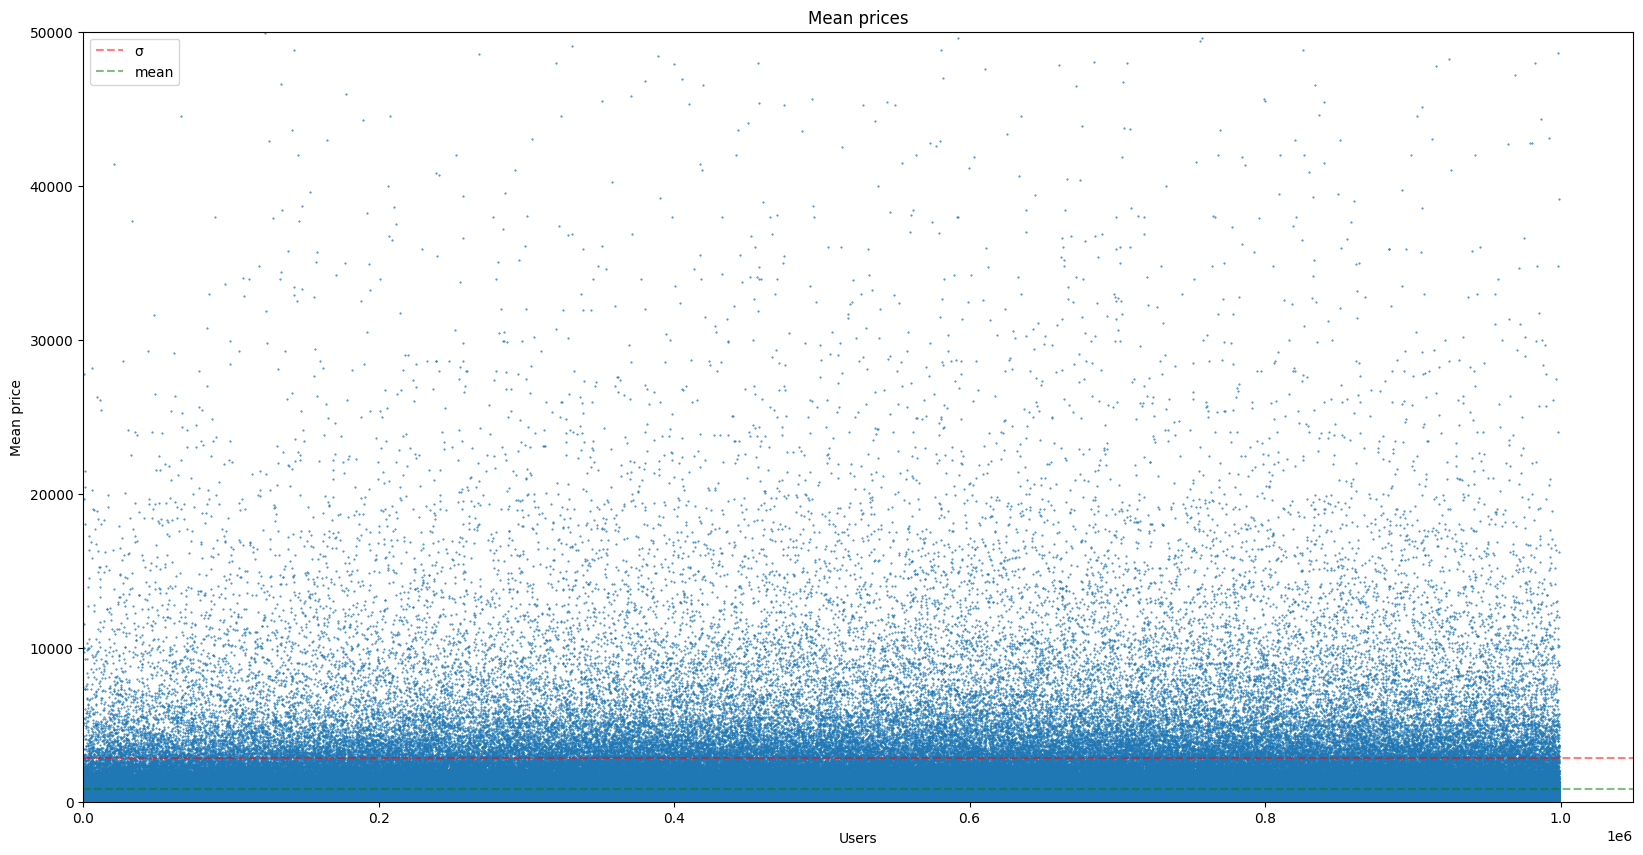

In [73]:
scatter_mean_prices(user_info, ylim=50_000)

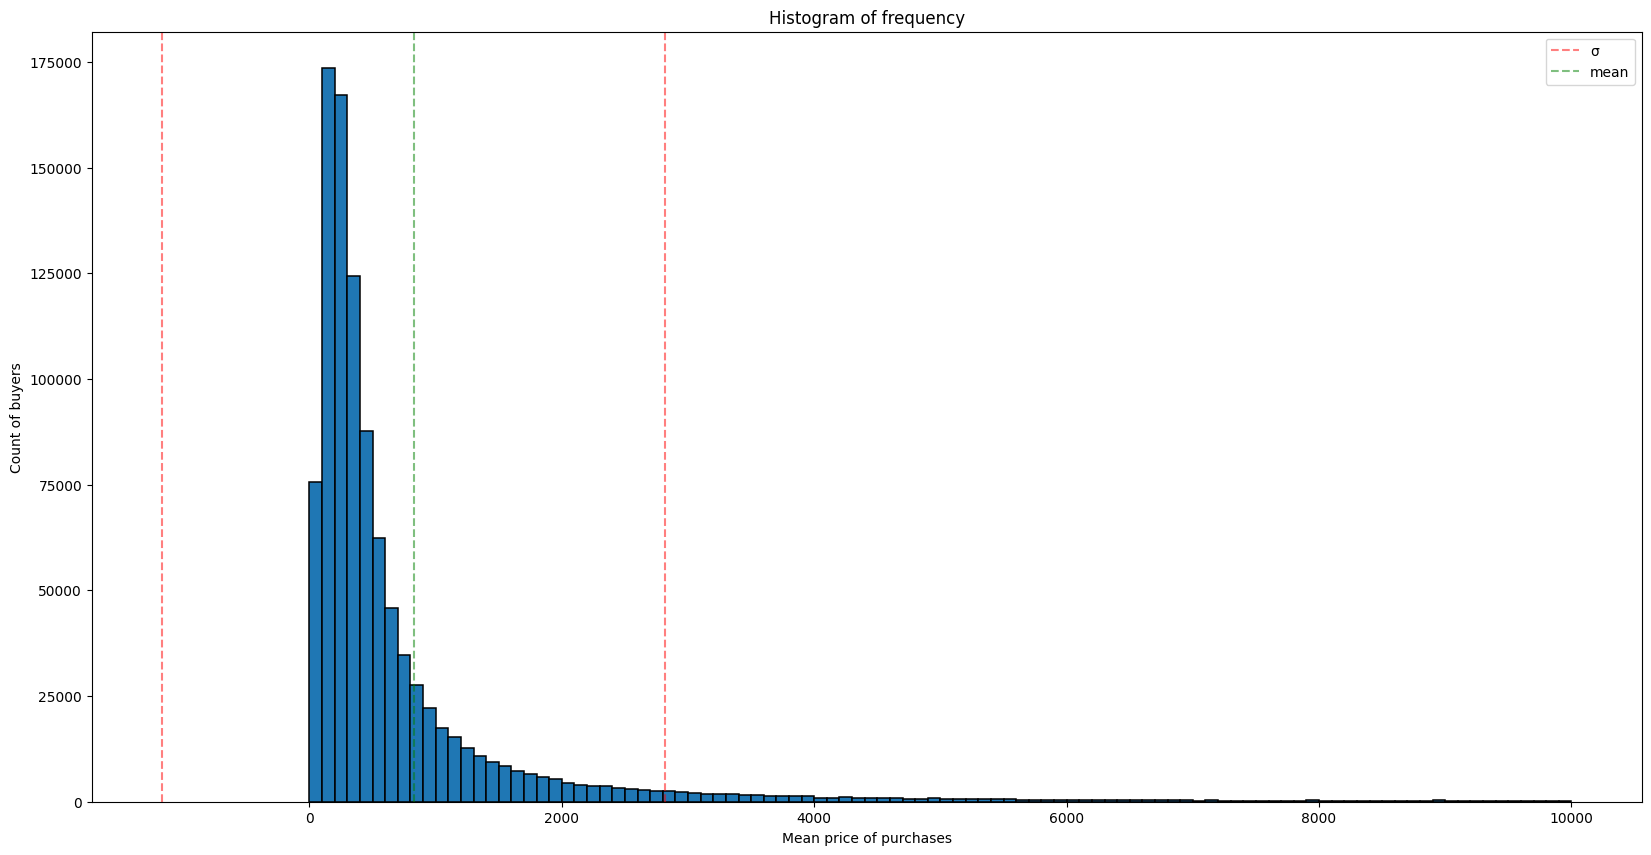

In [104]:
scatter_hist_of_prices(user_info, nbins=100, price_limit=(0, 10_000))

In [105]:
# del user_info

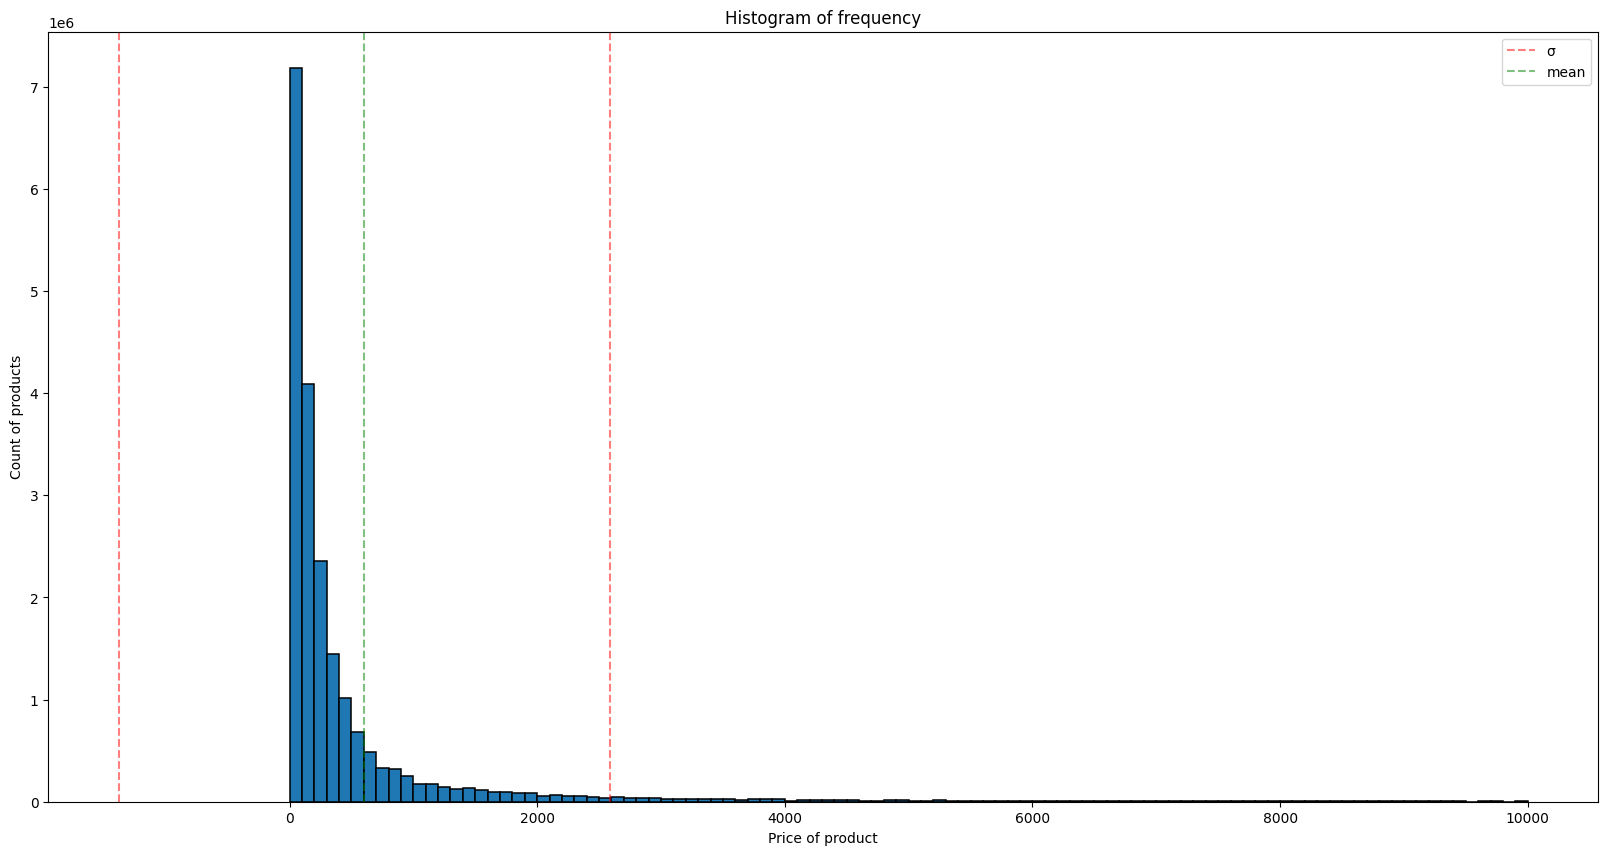

In [106]:
scatter_hist_of_products(data, nbins=100, price_limit=(0, 10_000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


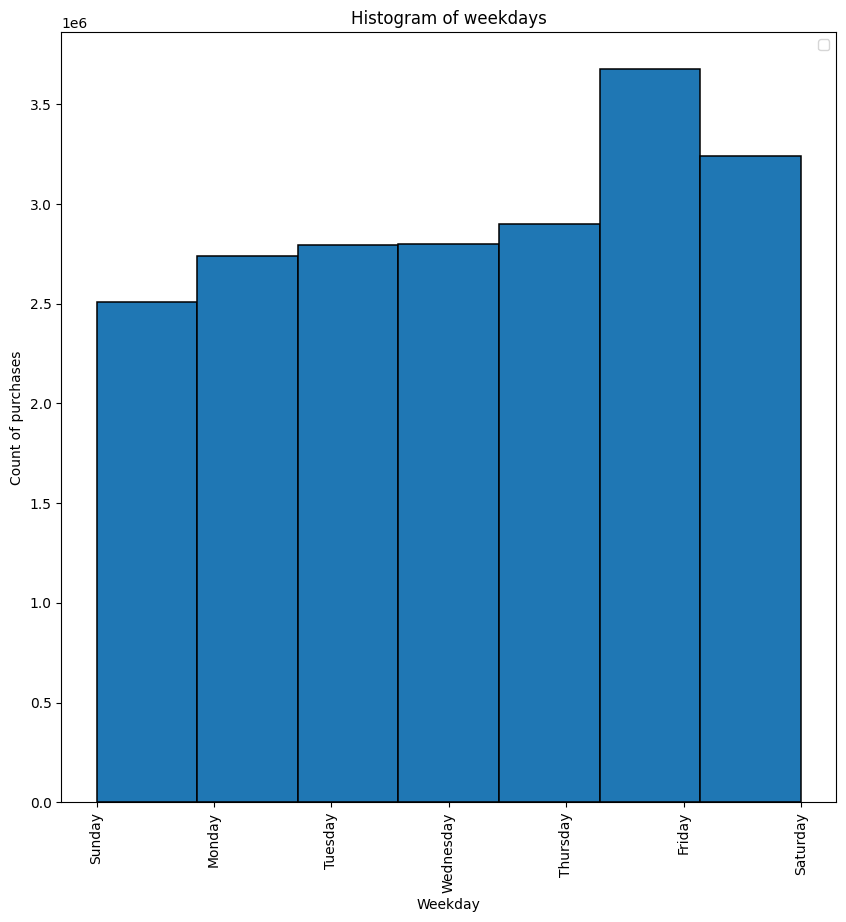

In [107]:
scatter_hist_of_weekdays(data)

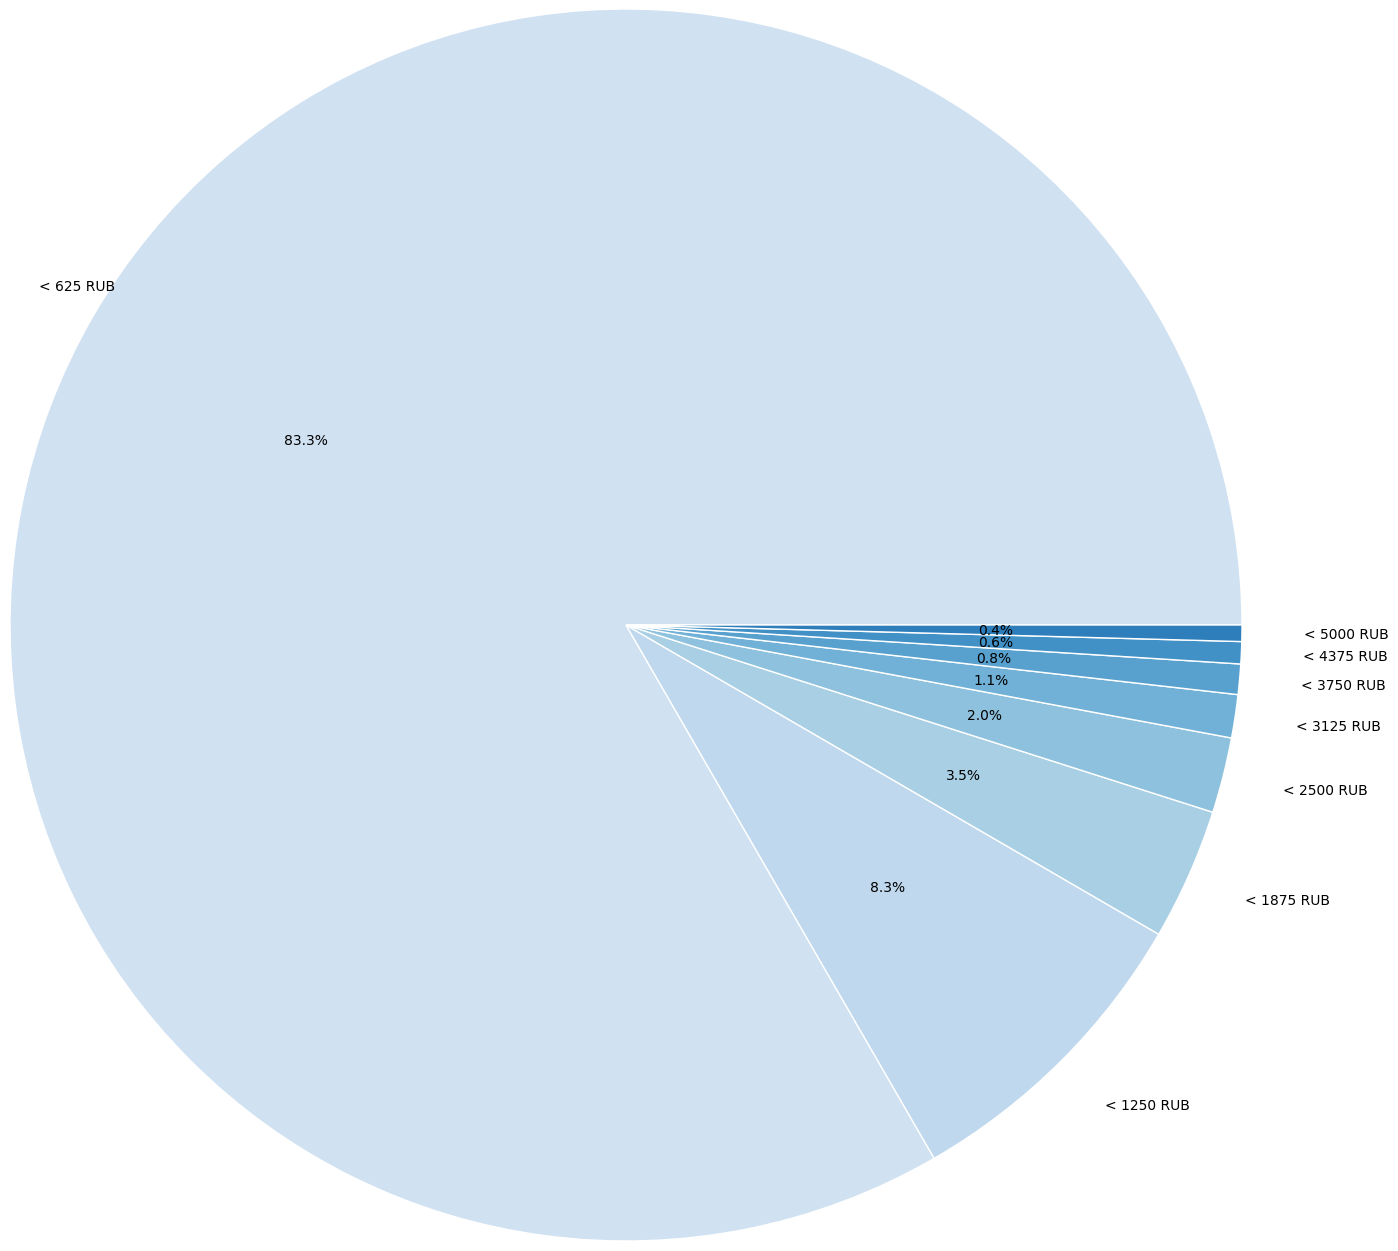

In [96]:
scatter_pie_of_prices(data, nbins=8, top_limit=5_000)

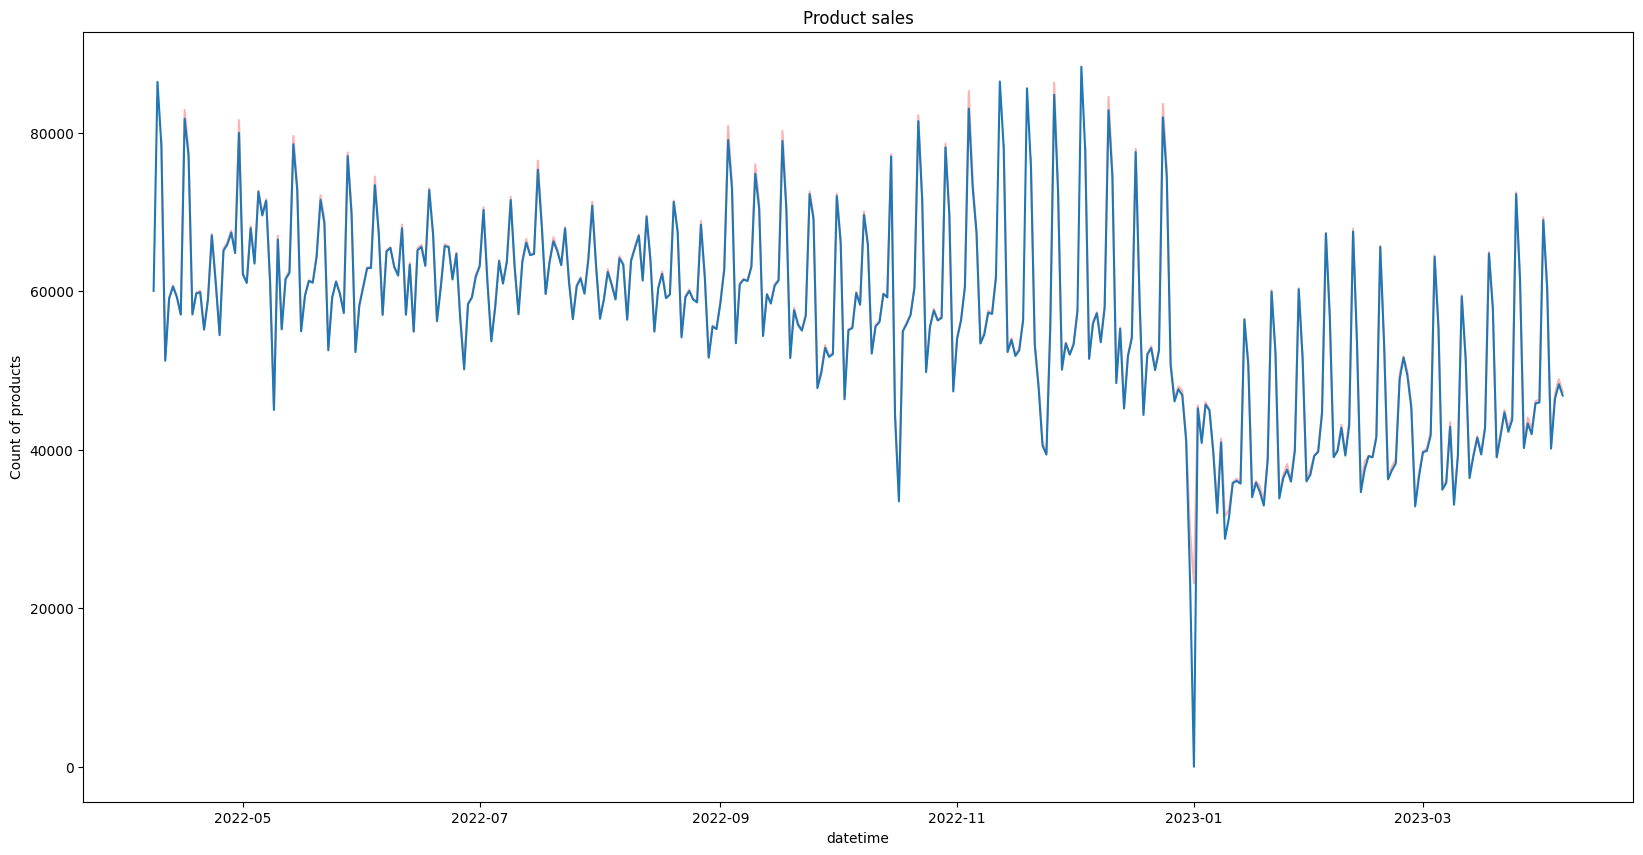

In [79]:
plot_over_time(data)

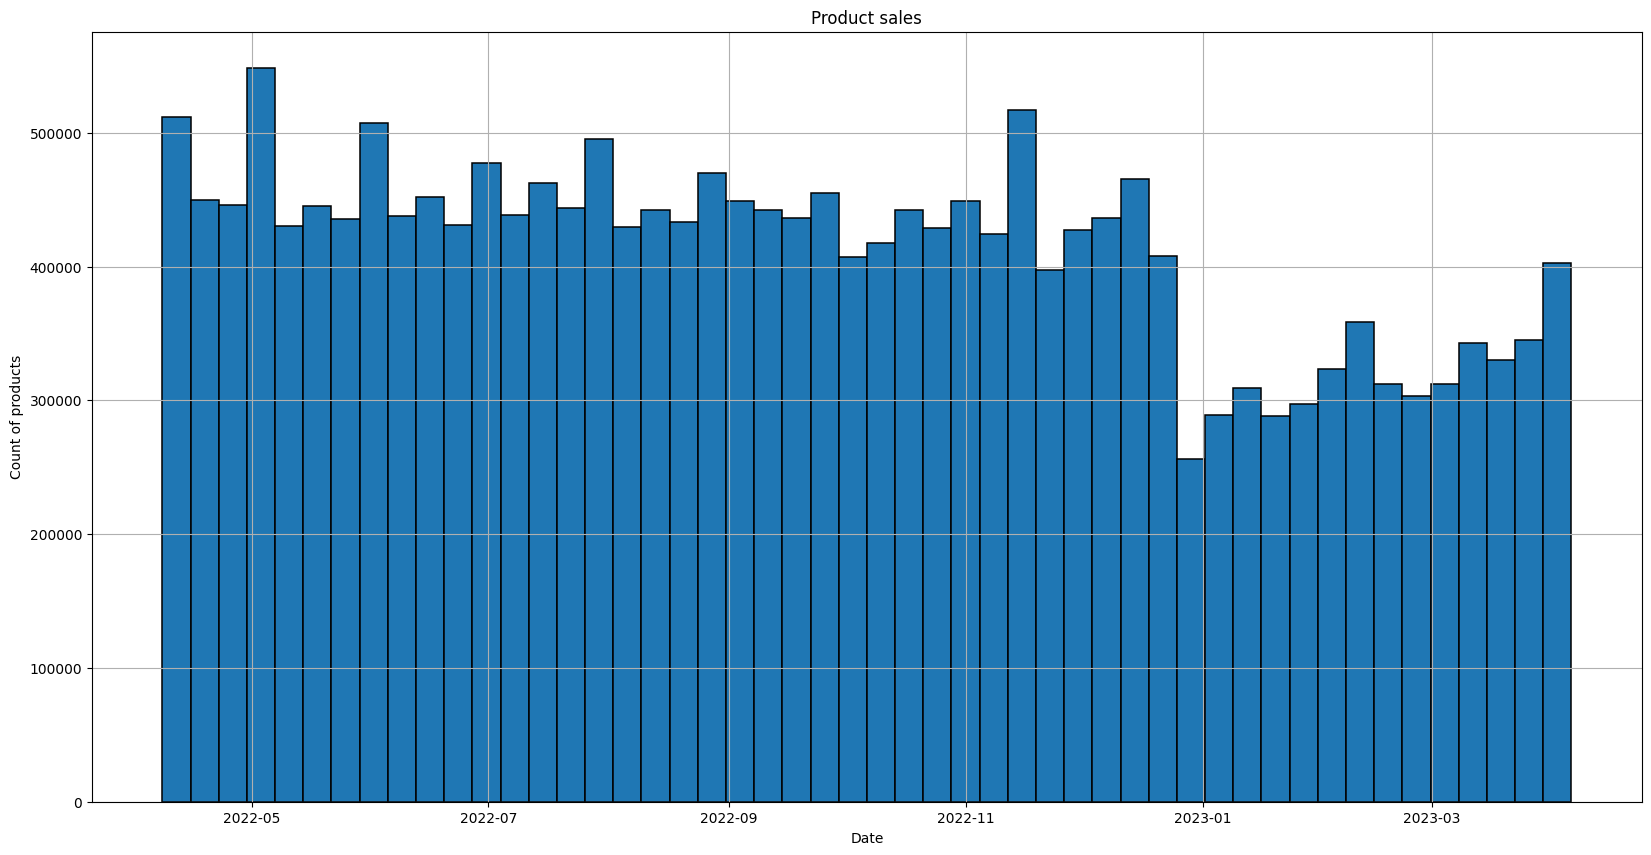

In [80]:
scatter_hist_over_time(data, nbins=50, plot_ma=False)

### Прогнозирование

In [81]:
# purchases = get_user_purchases(data, batch_size=100_000)
# purchases

In [82]:
# three_sigmas(purchases)

### Временные ряды

In [83]:
class Period:
    def __init__(self, date_from, date_to, date_type='%d.%m.%y'):
        self.start = datetime.strptime(date_from, date_type)
        self.end = datetime.strptime(date_to, date_type)

    def is_in(self, date):
        return self.start <= date <= self.end

    def includes(self, data):
        return data.loc[data.datetime >= self.start].loc[data.datetime <= self.end]

In [84]:
# def get_from_to(data, date_from, date_to, date_type='%d/%m/%y'):
#     return data.loc[data.datetime >= datetime.strptime(date_from, date_type)].loc[data.datetime <= datetime.strptime(date_to, date_type)]

def get_from_to(data, date_period):
    return date_period.includes(data)

def get_by_weekday(data, weekday):
    i = 0
    for ind in weekday_dict:
        if weekday == weekday_dict[ind]:
            i = ind
    return data.loc[data.weekday == i]

def sort_by_date(data):
    return data.sort_values(by=['datetime'])


# sort_by_date(get_from_to(data, '01.04.22', '20.12.22', '%d.%m.%y'))
# get_by_weekday(data, 'Четверг')

In [85]:

# sort_by_date(get_from_to(data, Period('01.04.22', '20.12.22', '%d.%m.%y')))

### Эластичность спроса по цене

In [86]:
def get_elasticity_over_periods(data, product_id, date_period_1, date_period_2):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]

    data_1 = date_period_1.includes(data)
    data_2 = date_period_2.includes(data)

    count_1 = data_1.shape[0]
    count_2 = data_2.shape[0]

    price_1 = data_1['line_item_price'].mean()
    price_2 = data_2['line_item_price'].mean()

    e = ((count_2 - count_1) / count_1) / ((price_2 - price_1) / price_1)
    return e

In [87]:
def get_dates_when_price_changed(data, product_id):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]
    when_changed = data['line_item_price'].shift() != data['line_item_price']#['datetime']
    return when_changed

In [88]:
# get_elasticity_over_periods(data, 18785635, Period('19.10.21', '20.12.22'), Period('20.12.22', '22.12.23'))

In [89]:
# get_dates_when_price_changed(data, 18785635)

In [90]:
import pandas_profiling
# prof = data.profile_report(progress_bar=True, explorative=True)

ModuleNotFoundError: No module named 'pandas_profiling'

In [ ]:
# prof = pandas_profiling.ProfileReport(data)
# prof.to_file(output_file='out/output.html')